Imports

In [1]:
from jitcdde import jitcdde_input, input, y, t
from parameters import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chspy import CubicHermiteSpline
import symengine as se

Define System

In [2]:
# delays
taus = [tau_c, tau_c_hx, tau_hx_c, tau_hx_r, tau_l, tau_r_hx]

# dT/dt for radiator nodes
T_out_rc = (W_rp/mn_rp)*(y(11,t-tau_hx_r)-y(0)) + (hA_rpn/mcp_rpn)*(y(1)-y(0))                  # T_out_rc: y(0)
T_out_air = -((W_rs/mn_rs)+(hA_rsn/mcp_rsn))*y(1) + (hA_rsn/mcp_rsn)*y(0) + (W_rs/mn_rs)*Trs_in # T_out_air: y(1)

# dT/dt for heat exchanger nodes
T_hf1 = -((W_p/mn_p)+(hA_pn/mcp_pn))*y(2) + (hA_pn/mcp_pn)*y(6) + (W_p/mn_p)*y(21,t-tau_c_hx)  # T_hf1: y(2)
T_hf2 = (W_p/mn_p)*(y(2)-y(3)) + (hA_pn/mcp_pn)*(y(6)-y(2))                                    # T_hf2: y(3)
T_hf3 = -((W_p/mn_p)+(hA_pn/mcp_pn))*y(4) + (hA_pn/mcp_pn)*y(7) + (W_p/mn_p)*y(3)              # T_hf3: y(4)
T_hf4 = (W_p/mn_p)*(y(4)-y(5)) + (hA_pn/mcp_pn)*(y(7)-y(4))                                    # T_hf4: y(5)
T_ht1 = (2*hA_pn/mcp_tn)*(y(2)-y(6)) + (2*hA_sn/mcp_tn)*(y(10)-y(6))                           # T_ht1: y(6)
T_ht2 = (2*hA_pn/mcp_tn)*(y(4)-y(7)) + (2*hA_sn/mcp_tn)*(y(8)-y(7))                            # T_ht2: y(7)
T_hc1 = -((W_s/mn_s)+(hA_sn/mcp_sn))*y(8) + (hA_sn/mcp_sn)*y(7) + (W_s/mn_s)*y(0,t-tau_r_hx)   # T_hc1: y(8)
T_hc2 = (W_s/mn_s)*(y(8)-y(9)) + (hA_sn/mcp_sn)*(y(7)-y(8))                                    # T_hc2: y(9)
T_hc3 = -((W_s/mn_s)+(hA_sn/mcp_sn))*y(10) + (hA_sn/mcp_sn)*y(6) + (W_s/mn_s)*y(9)             # T_hc3: y(10)
T_hc4 = (W_s/mn_s)*(y(10)-y(11)) + (hA_sn/mcp_sn)*(y(6)-y(10))                                 # T_hc4: y(11)

t_ins = 2500
inserted = 5e-4
def rho_insert(t):
    if (t<t_ins):
        return 0.0
    else:
        return inserted #*se.sin((1/60)*t)
    
spline = CubicHermiteSpline(n=1)
spline.from_function(rho_insert, times_of_interest = T)
rho_ext = input(0)

# dn/dt
n = (y(22)+rho_ext-beta_t)*y(12)/Lam+lam[0]*y(13)+lam[1]*y(14)+lam[2]*y(15)+lam[3]*y(16)+lam[4]*y(17)+lam[5]*y(18) # n (no source insertion): y(12)

# dC_i/dt (precursor concentrations)
C1 = y(12)*beta[0]/Lam-lam[0]*y(13)-y(13)/tau_c+y(13,t-tau_l)*np.exp(-lam[0]*tau_l)/tau_c  # C1: y(13)
C2 = y(12)*beta[1]/Lam-lam[1]*y(14)-y(14)/tau_c+y(14,t-tau_l)*np.exp(-lam[1]*tau_l)/tau_c  # C2: y(14)
C3 = y(12)*beta[2]/Lam-lam[2]*y(15)-y(15)/tau_c+y(15,t-tau_l)*np.exp(-lam[2]*tau_l)/tau_c  # C3: y(15)
C4 = y(12)*beta[3]/Lam-lam[3]*y(16)-y(16)/tau_c+y(16,t-tau_l)*np.exp(-lam[3]*tau_l)/tau_c  # C4: y(16)
C5 = y(12)*beta[4]/Lam-lam[4]*y(17)-y(17)/tau_c+y(17,t-tau_l)*np.exp(-lam[4]*tau_l)/tau_c  # C5: y(17)
C6 = y(12)*beta[5]/Lam-lam[5]*y(18)-y(18)/tau_c+y(18,t-tau_l)*np.exp(-lam[5]*tau_l)/tau_c  # C6: y(18)

# dT/dt core nodes
T_cg = (hA_fg/mcp_g1)*(y(20)-y(19)) + k_g*P*y(12)/mcp_g1                                             # T_cg: y(19)
T_cf1 = W_f/mn_f*(y(5,t-tau_hx_c)-y(20)) + (k_f1*P*y(12)/mcp_f1) + (hA_fg*k_1*(y(19)-y(20))/mcp_f1)  # T_cf1: y(20)
T_cf2 = W_f/mn_f*(y(20)-y(21)) + (k_f2*P*y(12)/mcp_f2) + (hA_fg*k_2*(y(19)-y(20))/mcp_f2)            # T_cf2: y(21)

# rho y(22)
rho = (a_f/2)*(T_cf1 + T_cf2) + (a_g)*(T_cg)

# initial reactivity 
rho_initial = 0.000

In [3]:
l = [T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
               T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho]

for d in l:
    print(d)

0.00227130968132373*(-current_y(0) + current_y(1)) + 0.256292182093792*(-current_y(0) + past_y(-4.71 + t, 11, anchors(-4.71 + t)))
1128.80834864453 + 0.595056568522384*current_y(0) - 30.4735200053814*current_y(1)
-2.810325940829*current_y(2) + 0.945852403920198*current_y(6) + 1.8644735369088*past_y(-3.77 + t, 21, anchors(-3.77 + t))
0.945852403920198*(-current_y(2) + current_y(6)) + 1.8644735369088*(current_y(2) - current_y(3))
1.8644735369088*current_y(3) - 2.810325940829*current_y(4) + 0.945852403920198*current_y(7)
0.945852403920198*(-current_y(4) + current_y(7)) + 1.8644735369088*(current_y(4) - current_y(5))
5.54283580016839*(current_y(2) - current_y(6)) + 2.61745023896841*(-current_y(6) + current_y(10))
5.54283580016839*(current_y(4) - current_y(7)) + 2.61745023896841*(-current_y(7) + current_y(8))
1.28444396919807*current_y(7) - 5.3205298452604*current_y(8) + 4.03608587606233*past_y(-8.24 + t, 0, anchors(-8.24 + t))
1.28444396919807*(current_y(7) - current_y(8)) + 4.036085876062

Solve with JiTCDDE

In [4]:
# instantiate jitcdde object
DDE = jitcdde_input([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
               T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho],spline)

# set initial conditions
DDE.constant_past([T0_rp, T0_rs, T0_p1,T0_p2, T0_p3, T0_p4, T0_t1, T0_t2, T0_s1, T0_s2, 
          T0_s3, T0_s4, n_frac0, C0[0], C0[1], C0[2], C0[3], C0[4], C0[5], 
          T0_g1, T0_f1, T0_f2,rho_initial])


In [5]:
sol_jit = []
for t_x in T:
    sol_jit.append(DDE.integrate(t_x))

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

In [6]:
# df = pd.read_excel('./data/msre_init.xlsx')
# df.head()

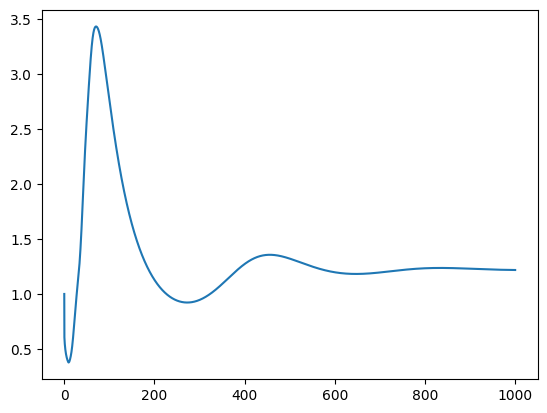

In [9]:
t0 = 0
tf = 5000
plt.plot(T,[s[12] for s in sol_jit])
# plt.plot(df["time"],df["Mux(4)"])
#plt.xlim([t0,tf])

Vary temeprature feedback coefficients

In [8]:
# solution vectors
sols = []
sols = [sol_jit]

# feedbacks
factors_f = [1/2, 1/4, 1/8, 0]
factors_g = [1/2, 1/4, 1/8, 0]

for i in range(len(factors_f)):

    # reinstantiate jitcdde objects
    import sys
    sys.modules.pop('jitcdde')
    from jitcdde import jitcdde, y, t

    # rho y(22)
    a_f_i = factors_f[i]
    a_g_i = factors_g[i]
    rho = a_f_i*(a_f/2)*(T_cf1 + T_cf2) + a_g_i*(a_g)*(T_cg)

    # instantiate jitcdde object
    DDE = jitcdde([T_out_rc,T_out_air,T_hf1,T_hf2,T_hf3,T_hf4,T_ht1,T_ht2,T_hc1,
                T_hc2,T_hc3,T_hc4,n,C1,C2,C3,C4,C5,C6,T_cg,T_cf1,T_cf2,rho])

    # set initial conditions
    DDE.constant_past([T0_rp, T0_rs, T0_p1,T0_p2, T0_p3, T0_p4, T0_t1, T0_t2, T0_s1, T0_s2, 
            T0_s3, T0_s4, n_frac0, C0[0], C0[1], C0[2], C0[3], C0[4], C0[5], 
            T0_g1, T0_f1, T0_f2,rho_initial])
    
    sol_i = []
    for t_x in T:
        sol_i.append(DDE.integrate(t_x))
    sols.append(sol_i)

Generating, compiling, and loading C code.


/tmp/jitcxde_qybeq7d1/f.c: In function ‘eval_f’:
/tmp/jitcxde_qybeq7d1/f.c:13:80: error: ‘external_input’ undeclared (first use in this function)
   13 | set_dy(12, 4166.66666666667*current_y(12)*(-0.006611 + current_y(22) + past_y(-external_input + t, input_base_n, anchors(-external_input + t))) + 0.0124*current_y(13) + 0.0305*current_y(14) + 0.111*current_y(15) + 0.301*current_y(16) + 1.14*current_y(17) + 3.014*current_y(18));
      |                                                                                ^~~~~~~~~~~~~~
/tmp/jitcxde_qybeq7d1/jitced_1.c:336:36: note: in definition of macro ‘set_dy’
  336 | # define set_dy(i, value) (dY[i] = value)
      |                                    ^~~~~
/tmp/jitcxde_qybeq7d1/f.c:13:72: note: in expansion of macro ‘past_y’
   13 | set_dy(12, 4166.66666666667*current_y(12)*(-0.006611 + current_y(22) + past_y(-external_input + t, input_base_n, anchors(-external_input + t))) + 0.0124*current_y(13) + 0.0305*current_y(14) + 0.111*current_y(1

AttributeError: 'tuple' object has no attribute 'tb_frame'

In [ ]:
fig,axs = plt.subplots(2,3,figsize=(18,12))

# fuel temps
#axs[0,0].set_xlim([0,20])
axs[0,0].plot(T,[s[20] for s in sols[0]],label="core 1") 
axs[0,0].plot(T,[s[21] for s in sols[0]],label="core 2") 
axs[0,0].plot(T,[s[2] for s in sols[0]],label="hx 1")  
axs[0,0].plot(T,[s[3] for s in sols[0]],label="hx 2")
axs[0,0].plot(T,[s[4] for s in sols[0]],label="hx 3")
axs[0,0].plot(T,[s[5] for s in sols[0]],label="hx 4")  
axs[0,0].legend()
axs[0,0].set_title("Fuel Node Temperatures (C)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# coolant temps
#axs[0,1].set_xlim([0,20])
axs[0,1].plot(T,[s[8] for s in sols[0]],label="hx 1") 
axs[0,1].plot(T,[s[9] for s in sols[0]],label="hx 2") 
axs[0,1].plot(T,[s[10] for s in sols[0]],label="hx 3")  
axs[0,1].plot(T,[s[11] for s in sols[0]],label="hx 4")
axs[0,1].plot(T,[s[0] for s in sols[0]],label="r 1")
axs[0,1].legend()
axs[0,1].set_title("Coolant Node Temperatures (C)")
axs[0,1].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# tube node temps
#axs[0,2].set_xlim([0,20])
axs[0,2].plot(T,[s[6] for s in sols[0]],label="hx 1") 
axs[0,2].plot(T,[s[7] for s in sols[0]],label="hx 2") 
axs[0,2].legend()
axs[0,2].set_title("Tube Node Temperatures (C)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# precursor concentrations
#axs[1,2].set_xlim([0,20])
axs[1,2].plot(T,[s[13] for s in sols[0]],label="C1") 
axs[1,2].plot(T,[s[14] for s in sols[0]],label="C2") 
axs[1,2].plot(T,[s[15] for s in sols[0]],label="C3")  
axs[1,2].plot(T,[s[16] for s in sols[0]],label="C4")
axs[1,2].plot(T,[s[17] for s in sols[0]],label="C5")
axs[1,2].plot(T,[s[18] for s in sols[0]],label="C6")
axs[1,2].legend()
axs[1,2].set_xlabel("t (s)")
axs[1,2].set_yscale("log")
axs[1,2].set_ylabel(r"concentration (1/cm$^3$)")
axs[1,2].legend(loc="right")
axs[1,2].set_title("Precursor Concentrations")

# multiplication factor temp
#axs[1,0].set_xlim([0,20])
axs[1,0].plot(T,[s[12] for s in sols[0]],label="n") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")

# reactivity
#axs[1,1].set_xlim([0,20])
axs[1,1].plot(T,[s[22] for s in sols[0]],label="n") 
axs[1,1].set_xlabel("t (s)")
axs[1,1].set_title(r"$\rho$")

#plt.figure(figsize=(8,6))
#plt.plot(T,[s[12] for s in sols[0]],label=r"$(\alpha_f,\alpha_g) = $ (-8.71,-6.66) pcm")
#plt.plot(T,[s[12] for s in sols[1]],label=r"$(\alpha_f,\alpha_g) = $ (-4.36,-3.33) pcm")
#plt.plot(T,[s[12] for s in sols[2]],label=r"$(\alpha_f,\alpha_g) = $ (-2.18,-1.67) pcm")
#plt.plot(T,[s[12] for s in sols[3]],label=r"$(\alpha_f,\alpha_g) = $ (-1.09,-0.83) pcm")
#plt.plot(T,[s[12] for s in sols[4]],label=r"$(\alpha_f,\alpha_g) = $ (0.0,0.0) pcm")
#plt.xlabel("t (s)")
#plt.ylabel(r"$n/n_0$",rotation=0)
#plt.legend()
#plt.ylim([0,20])
#plt.xlim([0,500])
#plt.title(r"Reactor Response vs $\alpha$")

In [ ]:
# heat exchanger energy extraction
p_in = [(W_p*scp_f*s[21]) for s in sols[0]]
p_out = [(W_p*scp_f*s[5]) for s in sols[0]]
extracted = np.subtract(p_in,p_out)
plt.plot(extracted)